In [1]:
# python imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import copy
import astropy as ap
#from astropy.io import fits
#from astropy.visualization import make_lupton_rgb
from astropy.cosmology import FlatLambdaCDM
import pandas as pd

# lenstronomy imports
# Util
from lenstronomy.Util import util
import lenstronomy.Util.image_util as image_util
import lenstronomy.Util.param_util as param_util
import lenstronomy.Util.simulation_util as sim_util
# Data
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
# ImSim
from lenstronomy.ImSim.image_model import ImageModel
# SimAPI
from lenstronomy.SimulationAPI.sim_api import SimAPI
# LensModel
from lenstronomy.LensModel.lens_model import LensModel 
# LightModel
from lenstronomy.LightModel.light_model import LightModel
# Plots
from lenstronomy.Plots.lens_plot import lens_model_plot
import lenstronomy.Plots.plot_util as plot_util
from lenstronomy.Plots import chain_plot
from lenstronomy.Plots.model_plot import ModelPlot
# Workflow
from lenstronomy.Workflow.fitting_sequence import FittingSequence
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver


In [2]:
# Data Specifics
background_rms = 7.  #  background noise per pixel 
exp_time = 90.  #  exposure time 
numPix = 45  #  cutout pixel size per axis
deltaPix = 0.2637  #  pixel size in arcsec
fwhm = 1 # close to g-band fwhm?
psf_type = 'GAUSSIAN' 
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

In [28]:
# Choices for simulation
theta_E = 2
ra_source = 0.1
dec_source = 0.1

Actual x-images: [ 2.1155302  -0.94875762  1.16605591 -1.17500875]
Actual y-images: [-0.63403825  1.88454159  1.61322942 -1.27309721]
[693.60869891 829.96548952 968.96495503 363.88452469]


/var/folders/6n/b2_b03_d65dc17frrw6ryn640000gn/T/ipykernel_39143/2867594373.py:84: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(image_sim), origin='lower', vmin=v_min, vmax=v_max, cmap=cmap, extent=[0, 1, 0, 1])


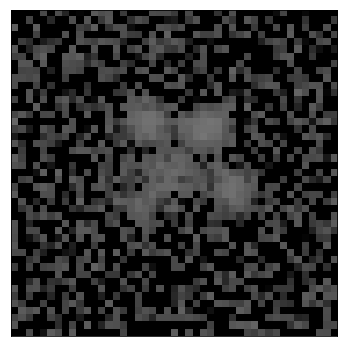

In [29]:
### Set models
# Lens: SIE
lens_model_list = ['SIE', 'SHEAR']
kwargs_spemd = {'theta_E': theta_E, 'center_x': 0., 'center_y': 0., 'e1': 0.05, 'e2': 0.05}  # parameters of the deflector lens model
kwargs_shear = {'gamma1': 0.05, 'gamma2': -0.05}  # shear values to the source plane
kwargs_lens = [kwargs_spemd, kwargs_shear]
lens_model_class = LensModel(lens_model_list)

# Source: Point source given source position    
# Calculate point source given source
source_model_list = ['SERSIC_ELLIPSE']
source_model_class = LightModel(light_model_list=source_model_list)
lensEquationSolver = LensEquationSolver(lens_model_class)
x_image, y_image = lensEquationSolver.findBrightImage(ra_source, dec_source, kwargs_lens, numImages=4,
                                                      min_distance=deltaPix, search_window=numPix * deltaPix)

print(f'Actual x-images: {x_image}')
print(f'Actual y-images: {y_image}')
# compute lensing magnification at image positions
mag = lens_model_class.magnification(x_image, y_image, kwargs=kwargs_lens)
mag = np.abs(mag)  # ignore the sign of the magnification??

point_amp = mag * 100 # multiply by intrinsic brightness??
kwargs_ps = [{'ra_image': x_image, 'dec_image': y_image,
                           'point_amp': point_amp}]
point_source_list = ['LENSED_POSITION']
point_source_class = PointSource(point_source_type_list=point_source_list, lensModel=lens_model_class, fixed_magnification_list=[False])
print(point_amp)


# Lens Light: Sersic Ellipse
kwargs_sersic_lens = {'amp': 300, 'R_sersic': 0.5, 'n_sersic': 1, 'e1': 0.1, 'e2': 0.1, 'center_x': 0, 'center_y': 0}
lens_light_model_list = ['SERSIC_ELLIPSE']
kwargs_lens_light = [kwargs_sersic_lens]
lens_light_model_class = LightModel(lens_light_model_list)

### Make Image
# image properties
_, _, ra_at_xy_0, dec_at_xy_0, _, _, Mpix2coord, _ = util.make_grid_with_coordtransform(numPix=numPix, deltapix=deltaPix, center_ra=0, center_dec=0, subgrid_res=1, inverse=False)
kwargs_data = {'background_rms': background_rms,  
               'exposure_time': exp_time,  
               'ra_at_xy_0': ra_at_xy_0,  
               'dec_at_xy_0': dec_at_xy_0,  
               'transform_pix2angle': Mpix2coord,  
               'image_data': np.zeros((numPix, numPix)) 
              }

data_class = ImageData(**kwargs_data)

# PSF
kwargs_psf = {'psf_type': psf_type, 'fwhm': fwhm, 'pixel_size': deltaPix, 'truncation': 3}
psf_class = PSF(**kwargs_psf)

kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}

imageModel = ImageModel(data_class, psf_class, lens_model_class=lens_model_class, 
                        point_source_class = point_source_class,
                        lens_light_model_class=lens_light_model_class,
                        kwargs_numerics=kwargs_numerics)

# generate image
image_model = imageModel.image(kwargs_lens = kwargs_lens, 
                               kwargs_lens_light=kwargs_lens_light, 
                               kwargs_ps=kwargs_ps)

poisson = image_util.add_poisson(image_model, exp_time=exp_time)
bkg = image_util.add_background(image_model, sigma_bkd=7)
image_sim = image_model + poisson + bkg

data_class.update_data(image_sim)
kwargs_data['image_data'] = image_sim

# display image
cmap = mpl.cm.get_cmap("gray").copy()
cmap.set_bad(color='k', alpha=1.)
cmap.set_under('k')

v_min = -1
v_max = 5

f, axes = plt.subplots(1, 1, figsize=(6, 6), sharex=False, sharey=False)

ax = axes
im = ax.matshow(np.log10(image_sim), origin='lower', vmin=v_min, vmax=v_max, cmap=cmap, extent=[0, 1, 0, 1])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)

plt.show()
plt.close()



In [47]:
def model(theta_E, kwargs_lens_initial, kwargs_ps_initial, kwargs_lens_light_initial):
    """
    Input theta_E, and Initial lens, point source (images), and lens-light guesses
    
    Output: Plots of observed image, modeled image, and residuals 
    
    """
    # set models: 
    lens_model_list = ['SIE', 'SHEAR']
    source_model_list = ['SERSIC_ELLIPSE']
    lens_light_model_list = ['SERSIC_ELLIPSE']
    point_source_list = ['LENSED_POSITION']
    
    # Initial guesses, sigma, and absolute bounds
    # lens     
    kwargs_lens_fixed = [{}, {'ra_0': 0, 'dec_0': 0}]
    kwargs_lens_init = []
    kwargs_lens_sigma = []
    kwargs_lower_lens = []
    kwargs_upper_lens = []

    kwargs_lens_init.append(kwargs_lens_initial) 
    kwargs_lens_sigma.append({'theta_E': .1, 'e1': 0.05, 'e2': 0.05, 'center_x': 0.05, 'center_y': 0.05})
    kwargs_lower_lens.append({'theta_E': 2., 'e1': -0.2, 'e2': -0.2, 'center_x': -1, 'center_y': -1})
    kwargs_upper_lens.append({'theta_E': 5., 'e1': 0.2, 'e2': 0.2, 'center_x': 1, 'center_y': 1})

    kwargs_lens_init.append({'gamma1': 0., 'gamma2': 0.})
    kwargs_lens_sigma.append({'gamma1': 0.05, 'gamma2': 0.05})
    kwargs_lower_lens.append({'gamma1': -0.2, 'gamma2': -0.2})
    kwargs_upper_lens.append({'gamma1': 0.2, 'gamma2': 0.2})

    lens_params = [kwargs_lens_init, kwargs_lens_sigma, kwargs_lens_fixed, kwargs_lower_lens, kwargs_upper_lens]
    
    # point source
    fixed_ps = [{}]
    kwargs_ps_init = []
    kwargs_ps_sigma = []
    kwargs_lower_ps = []
    kwargs_upper_ps = []

    kwargs_ps_init.append(kwargs_ps_initial)
    kwargs_ps_sigma = [{'ra_image': [0.02] * 4, 'dec_image': [0.02] * 4}] # sigma of 0.02 for each image in lists
    kwargs_lower_ps = [{'ra_image': -1 * np.ones_like(x_images), 'dec_image': -1 * np.ones_like(y_images)}] # upper and lower bounds of 2 times initial guess for each image in lists
    kwargs_upper_ps = [{'ra_image': 1.5 * np.ones_like(x_images), 'dec_image': 1.5 * np.ones_like(y_images)}]

    ps_params = [kwargs_ps_init, kwargs_ps_sigma, fixed_ps, kwargs_lower_ps, kwargs_upper_ps]

    # lens light
    fixed_lens_light = [{}]
    kwargs_lens_light_init = []
    kwargs_lens_light_sigma = []
    kwargs_lower_lens_light = []
    kwargs_upper_lens_light = []

    kwargs_lens_light_init.append(kwargs_lens_light_initial) 
    kwargs_lens_light_sigma.append({'n_sersic': 0.1, 'R_sersic': 0.05, 'e1': 0.05, 'e2': 0.05, 'center_x': 0.1, 'center_y': 0.1})
    kwargs_lower_lens_light.append({'e1': -0.2, 'e2': -0.2, 'R_sersic': 0.1, 'n_sersic': .5, 'center_x': -1, 'center_y': -1})
    kwargs_upper_lens_light.append({'e1': 0.2, 'e2': 0.2, 'R_sersic': 1., 'n_sersic': 1.5, 'center_x': 1, 'center_y': 1})

    lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, fixed_lens_light, kwargs_lower_lens_light, kwargs_upper_lens_light]

    kwargs_params = {'lens_model': lens_params,
                'point_source_model': ps_params,
                'lens_light_model': lens_light_params}
    
    # Fitting Sequence (computing results)
    # data for fitting
    _, _, ra_at_xy_0, dec_at_xy_0, _, _, Mpix2coord, _ = util.make_grid_with_coordtransform(numPix=numPix, deltapix=deltaPix, center_ra=0, center_dec=0, subgrid_res=1, inverse=False)
    kwargs_data = {'background_rms': background_rms,  
                   'exposure_time': exp_time,  
                   'ra_at_xy_0': ra_at_xy_0,  
                   'dec_at_xy_0': dec_at_xy_0,  
                   'transform_pix2angle': Mpix2coord,  
                   'image_data': image_sim # simulated image
                  }
    kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}
    kwargs_psf = {'psf_type': psf_type, 'fwhm': fwhm, 'pixel_size': deltaPix, 'truncation': 3}
    kwargs_model = {'lens_model_list': lens_model_list, 
                    'point_source_model_list': point_source_list,
                    'lens_light_model_list': lens_light_model_list}
    
    multi_band_list = [[kwargs_data, kwargs_psf, kwargs_numerics]] # the simulated image is only a single band
    kwargs_data_joint = {'multi_band_list': multi_band_list, 
                         'multi_band_type': 'multi-linear'
                        }
    kwargs_constraints = {'num_point_source_list': [4],
                          'solver_type': 'PROFILE'
                          }
    
    kwargs_likelihood = {'check_bounds': True,
                         'force_no_add_image': False,
                         'source_marg': False,
                         'image_position_uncertainty': 0.004, # check likelihood of images
                         'check_matched_source_position': True,
                         'source_position_tolerance': 0.001,
                         'source_position_sigma': 0.001
                        }
    
    # fitting
    fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)
    fitting_kwargs_list = [['PSO', {'sigma_scale': 1., 'n_particles': 100, 'n_iterations': 100}], 
                       ['MCMC', {'n_burn': 20, 'n_run': 60, 'walkerRatio': 10, 'sigma_scale': .1}]]

    chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
    kwargs_result = fitting_seq.best_fit()

    # plot model
    modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat")
    
    f, axes = plt.subplots(1, 3, figsize=(16, 8), sharex=False, sharey=False)

    modelPlot.data_plot(ax=axes[0])
    modelPlot.model_plot(ax=axes[1])
    modelPlot.normalized_residual_plot(ax=axes[2], v_min=-6, v_max=6)
    #modelPlot.source_plot(ax=axes[1, 0], deltaPix_source=0.01, numPix=100)
    #modelPlot.convergence_plot(ax=axes[1, 1], v_max=1)
    #modelPlot.magnification_plot(ax=axes[1, 2])

    f.tight_layout()
    f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
    plt.show()
    plt.close()
    
    print(kwargs_result)


In [48]:
# set initial guesses
x_images = [ 3.3, -0.9,  1.6, -1.7]
y_images = [-0.6,  3.0,  2.6,   -1.8]

kwargs_lens_initial = {'theta_E': 2, 'e1': 0.05, 'e2': 0.05,'center_x': 0., 'center_y': 0.}
kwargs_lens_light_initial = {'R_sersic': 0.5, 'n_sersic': 1, 'e1': 0., 'e2': 0., 'center_x': 0, 'center_y': 0}
kwargs_ps_initial = {'ra_image': x_image, 'dec_image': y_image}


Computing the PSO ...
10
20
30
40
50
60
Converged after 63 iterations!
Best fit found:  -1000000000000000 [0.0, 0.0, 0.5, 1.0, 0.0, 0.0, 0.0, 0.0, 2.1155302008937866, -0.9487576182455942, 1.1660559071712833, -1.1750087497655293, -0.6340382518820886, 1.8845415852016576, 1.6132294194339454, -1.2730972127540063]
-998003992015.968 reduced X^2 of best position
-1000000000000000 logL
2004.0 effective number of data points
[{'theta_E': 2.03554000667518, 'e1': -0.0412304447019056, 'e2': 0.20498694678553783, 'center_x': -0.05987872606224868, 'center_y': -0.09196199243069239}, {'gamma1': 0.0, 'gamma2': 0.0, 'ra_0': 0, 'dec_0': 0}] lens result
[] source result
[{'amp': 1, 'R_sersic': 0.5, 'n_sersic': 1.0, 'e1': 0.0, 'e2': 0.0, 'center_x': 0.0, 'center_y': 0.0}] lens light result
[{'ra_image': array([ 2.1155302 , -0.94875762,  1.16605591, -1.17500875]), 'dec_image': array([-0.63403825,  1.88454159,  1.61322942, -1.27309721]), 'point_amp': array([1., 1., 1., 1.])}] point source result
{} special pa

100%|███████████████████████████████████████████| 80/80 [01:01<00:00,  1.29it/s]


Computing the MCMC...
Number of walkers =  160
Burn-in iterations:  20
Sampling iterations (in current run): 80
62.81784987449646 time taken for MCMC sampling
-1.12780629253785 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  1.12780629253785


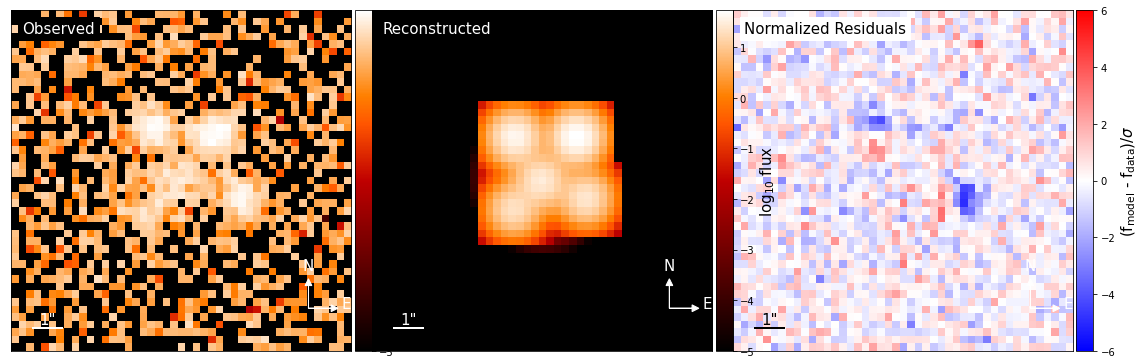

{'kwargs_lens': [{'theta_E': 1.64985504961587, 'e1': 0.015324605869725155, 'e2': 0.004840243318468765, 'center_x': 0.09963033336226379, 'center_y': 0.2474330778218316}, {'gamma1': 0.009471713333532054, 'gamma2': 0.008442621406870314, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [], 'kwargs_lens_light': [{'amp': 1054.6547878852489, 'R_sersic': 0.2228492052908082, 'n_sersic': 0.7583341039713188, 'e1': -0.045409104668591604, 'e2': -0.0523300178876016, 'center_x': -0.046690192839827616, 'center_y': -0.01416365240786468}], 'kwargs_ps': [{'ra_image': array([ 1.49990901, -0.95467289,  1.18577224, -0.99996004]), 'dec_image': array([-0.61110398,  1.49995093,  1.49910665, -0.99998509]), 'point_amp': array([ 449.50387774,  728.92522187, 1003.52818839,  365.82560656])}], 'kwargs_special': {}, 'kwargs_extinction': []}


In [49]:
# testing modeling using simulation
model(theta_E, kwargs_lens_initial, kwargs_ps_initial, kwargs_lens_light_initial)
